YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'Strategy Cumulative Return'}, xlabel='Date'>

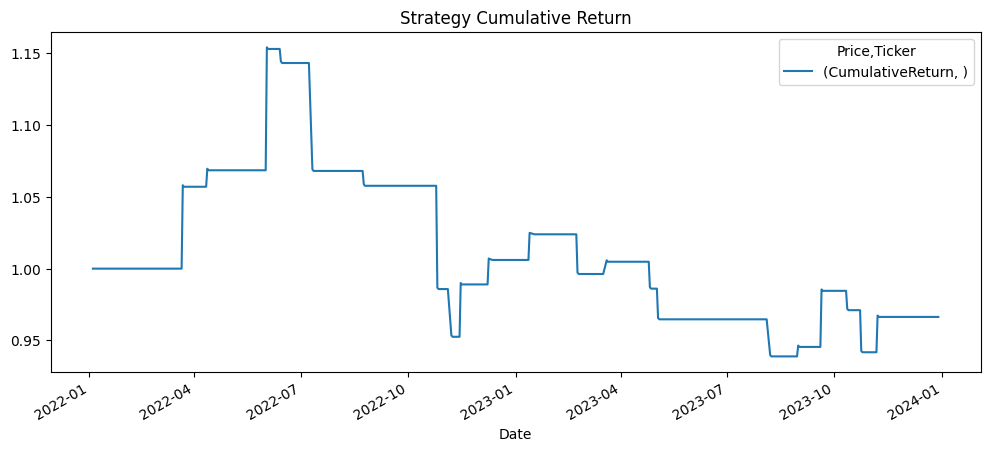

In [1]:
import sys
import os

# 让 notebook 能识别 utils/ 里的 py 文件
sys.path.append(os.path.abspath("../utils"))

from backtest import simple_backtest
import yfinance as yf
import matplotlib.pyplot as plt

# 获取数据
df = yf.download("TQQQ", start="2022-01-01", end="2023-12-31")
df["MA5"] = df["Close"].rolling(5).mean()
df["MA20"] = df["Close"].rolling(20).mean()

# 策略逻辑（金叉买入，死叉卖出）
df["Signal"] = 0
df.loc[(df["MA5"] > df["MA20"]) & (df["MA5"].shift(1) <= df["MA20"].shift(1)), "Signal"] = 1
df.loc[(df["MA5"] < df["MA20"]) & (df["MA5"].shift(1) >= df["MA20"].shift(1)), "Signal"] = -1

# 回测
df_bt = simple_backtest(df)

# 可视化策略 vs benchmark
df_bt[["CumulativeReturn"]].plot(figsize=(12, 5), title="Strategy Cumulative Return")



In [2]:
import sys, os
sys.path.append(os.path.abspath("../utils"))

from evaluate import evaluate_strategy

# 评估表现
metrics = evaluate_strategy(df_bt)
print(metrics)

{'年化收益': np.float64(-0.0102), '年化波动': np.float64(0.1187), '夏普比率': np.float64(-0.0863), '最大回撤': np.float64(-0.1865)}


<Axes: title={'center': '策略 vs 指数'}, xlabel='Date'>

/Users/odnwo/odnwo/Quant/Jupyter/conda_install/miniconda3/envs/quant-env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/odnwo/odnwo/Quant/Jupyter/conda_install/miniconda3/envs/quant-env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 30053 (\N{CJK UNIFIED IDEOGRAPH-7565}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/odnwo/odnwo/Quant/Jupyter/conda_install/miniconda3/envs/quant-env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/odnwo/odnwo/Quant/Jupyter/conda_install/miniconda3/envs/quant-env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/odnwo/odnwo/Q

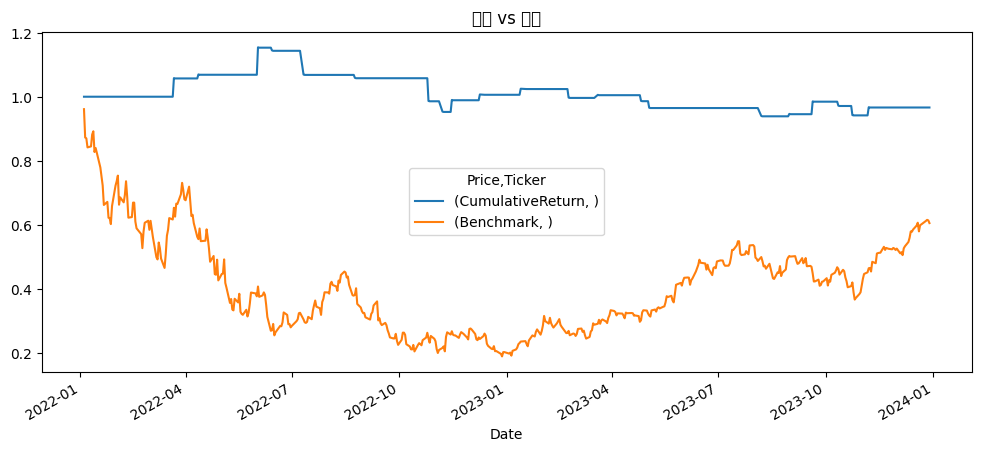

In [3]:
# 添加 benchmark（市场指数收益）
df_bt["Benchmark"] = (1 + df_bt["Return"]).cumprod()

# 可视化策略 vs benchmark
df_bt[["CumulativeReturn", "Benchmark"]].plot(figsize=(12, 5), title="策略 vs 指数")

In [4]:
metrics = evaluate_strategy(df_bt)
print(metrics)

{'年化收益': np.float64(-0.0102), '年化波动': np.float64(0.1187), '夏普比率': np.float64(-0.0863), '最大回撤': np.float64(-0.1865)}


In [5]:
# 仅当信号变化时才换仓（去重信号）
df["CleanSignal"] = df["Signal"]
df["CleanSignal"] = df["CleanSignal"].mask(df["CleanSignal"] == df["CleanSignal"].shift(1))

df_bt = simple_backtest(df, signal_col="CleanSignal")

metrics = evaluate_strategy(df_bt)
print(metrics)

{'年化收益': np.float64(-0.0102), '年化波动': np.float64(0.1187), '夏普比率': np.float64(-0.0863), '最大回撤': np.float64(-0.1865)}


In [7]:
df_bt = simple_backtest(df, signal_col="CleanSignal", fee=0.001)
metrics = evaluate_strategy(df_bt)
print(metrics)

# 画出策略 vs 指数对比曲线（加了 benchmark）
# df_bt[["CumulativeReturn", "Benchmark"]].plot(figsize=(12, 5), title="策略 vs 指数")

# 打印一下 Trade 列，观察是否交易频率下降了
# df_bt[["Position", "Trade"]].tail(20)
# 如果你用的是 CleanSignal，你会看到 Trade=1 的行明显减少了

{'年化收益': np.float64(-0.0102), '年化波动': np.float64(0.1187), '夏普比率': np.float64(-0.0863), '最大回撤': np.float64(-0.1865)}
